# Doing Bayesian Deep Learning on Transformers

In this notebook we describe the process that we took to train our models using Vadam [Emtiyaz Khan et. al, 2018](https://arxiv.org/pdf/1806.04854.pdf) and SGLD [Welling, Teh, 2011](https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf)

# Setup

####For Colab only

Set path root folder after change directory command

In [ ]:
# # mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

# # change to directory containing relevant files
#%cd INSERT DIRECTORY

Mounted at /content/drive


In [ ]:
#@title Run to check we're in the correct directory

#try:
  #  f = open("check_directory.txt")
  #  print('Success :)')
#except IOError:
  #  print("Wrong directory, please try again")

In [ ]:
!pip install transformers
!pip install barbar

Importing Generic Libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from barbar import Bar
from torch.optim.optimizer import Optimizer
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import math
import pickle
import copy

import matplotlib
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, AdamW
import os

Functions needed to load and preprocess data. Source:[https://github.com/hendrycks/ethics](https://github.com/hendrycks/ethics)

In [ ]:
def load_model(args, load_path=None, cache_dir=None):
    if cache_dir is not None:
        config = AutoConfig.from_pretrained(args.model, num_labels=1, cache_dir=cache_dir)
    else:
        config = AutoConfig.from_pretrained(args.model, num_labels=1)
    model = AutoModelForSequenceClassification.from_pretrained(args.model, config=config)
    if load_path is not None:
        model.load_state_dict(torch.load(load_path), strict=False)

    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=[i for i in range(args.ngpus)])

    print('\nPretrained model "{}" loaded'.format(args.model))
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters()
                    if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters()
                    if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=1e-8)

    return model, optimizer

def load_process_data(args, data_dir, dataset, name="train"):
    load_fn = load_util_sentences
    sentences, labels = load_fn(data_dir, name=name)
    sentences = ["[CLS] " + s for s in sentences]
    tokenizer = get_tokenizer(args.model)
    ids, amasks = get_ids_mask(sentences, tokenizer, args.max_length)
    within_bounds = [ids[i, -1] == 0 for i in range(len(ids))]
    if np.mean(within_bounds) < 1:
        print("{} fraction of examples within context window ({} tokens): {:.3f}".format(name, args.max_length, np.mean(within_bounds)))
    inputs, labels, masks = torch.tensor(ids), torch.tensor(labels), torch.tensor(amasks)

    even_mask = [i for i in range(inputs.shape[0]) if i % 2 == 0]
    odd_mask = [i for i in range(inputs.shape[0]) if i % 2 == 1]
    even_inputs, odd_inputs = inputs[even_mask], inputs[odd_mask]
    even_labels, odd_labels = labels[even_mask], labels[odd_mask]
    even_masks, odd_masks = masks[even_mask], masks[odd_mask]
    inputs = torch.stack([even_inputs, odd_inputs], axis=1)
    labels = torch.stack([even_labels, odd_labels], axis=1)
    masks = torch.stack([even_masks, odd_masks], axis=1)

    data = TensorDataset(inputs, masks, labels)
    return data

def load_util_sentences(data_dir, name="train"):
    path = os.path.join(data_dir, "{}.csv".format(name))
    df = pd.read_csv(path, header=None)
    sentences = []
    for i in range(df.shape[0]):
        sentences.append(df.iloc[i, 0])
        sentences.append(df.iloc[i, 1])
    labels = [-1 for _ in range(len(sentences))]
    return sentences, labels

def get_tokenizer(model):
    tokenizer = AutoTokenizer.from_pretrained(model)
    return tokenizer

def get_ids_mask(sentences, tokenizer, max_length):
    tokenized = [tokenizer.tokenize(s) for s in sentences]
    tokenized = [t[:(max_length - 1)] + ['SEP'] for t in tokenized]

    ids = [tokenizer.convert_tokens_to_ids(t) for t in tokenized]
    ids = np.array([np.pad(i, (0, max_length - len(i)),
                           mode='constant') for i in ids])

    amasks = []
    for seq in ids:
        seq_mask = [float(i > 0) for i in seq]
        amasks.append(seq_mask)
    return ids, amasks
  
def flatten(tensor):
    tensor = torch.cat([tensor[:, 0], tensor[:, 1]])
    return tensor

def unflatten(tensor):
    tensor = torch.stack([tensor[:tensor.shape[0] // 2], tensor[tensor.shape[0] // 2:]], axis=1)
    return tensor



The Optimizers that we use. Sources:

 Vadam: [https://github.com/emtiyaz/vadam](https://github.com/emtiyaz/vadam)

 SGLD: [https://github.com/noahgolmant/SGLD/blob/master/sgld/optimizers.py](https://github.com/noahgolmant/SGLD/blob/master/sgld/optimizers.py) 

In [ ]:
#@title
class Vadam(Optimizer):
    """Implements Vadam algorithm.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        train_set_size (int): number of data points in the full training set 
            (objective assumed to be on the form (1/M)*sum(-log p))
        lr (float, optional): learning rate (default: 1e-3)
        beta (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        prior_prec (float, optional): prior precision on parameters
            (default: 1.0)
        prec_init (float, optional): initial precision for variational dist. q
            (default: 1.0)
        num_samples (float, optional): number of MC samples
            (default: 1)
    """

    def __init__(self, params, train_set_size, lr=1e-3, betas=(0.9, 0.999), prior_prec=1.0, prec_init=1.0, num_samples=1):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= prior_prec:
            raise ValueError("Invalid prior precision value: {}".format(prior_prec))
        if not 0.0 <= prec_init:
            raise ValueError("Invalid initial s value: {}".format(prec_init))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if num_samples < 1:
            raise ValueError("Invalid num_samples parameter: {}".format(num_samples))
        if train_set_size < 1:
            raise ValueError("Invalid number of training data points: {}".format(train_set_size))
            
        self.num_samples = num_samples
        self.train_set_size = train_set_size

        defaults = dict(lr=lr, betas=betas, prior_prec=prior_prec, prec_init=prec_init)
        super(Vadam, self).__init__(params, defaults)

    def step(self, closure):
        """Performs a single optimization step.
        Arguments:
            closure (callable): A closure that reevaluates the model
                and returns the loss.
        """
        if closure is None:
            raise RuntimeError('For now, Vadam only supports that the model/loss can be reevaluated inside the step function')
            
        grads = []
        grads2 = []
        for group in self.param_groups:
                for p in group['params']:
                    grads.append([])
                    grads2.append([])
        
        # Compute grads and grads2 using num_samples MC samples
        for s in range(self.num_samples):
            
            # Sample noise for each parameter
            pid = 0
            original_values = {}
            for group in self.param_groups:
                for p in group['params']:
    
                    original_values.setdefault(pid, p.detach().clone())
                    state = self.state[p]
                    # State initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p.data)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.ones_like(p.data) * (group['prec_init'] - group['prior_prec']) / self.train_set_size
    
                    # A noisy sample
                    raw_noise = torch.normal(mean=torch.zeros_like(p.data), std=1.0)
                    p.data.addcdiv_(1., raw_noise, torch.sqrt(self.train_set_size * state['exp_avg_sq'] + group['prior_prec']))
                    
                    pid = pid + 1
    
            # Call the loss function and do BP to compute gradient
            loss = closure()
            
            # Replace original values and store gradients
            pid = 0
            for group in self.param_groups:
                for p in group['params']:
                    
                    # Restore original parameters
                    p.data = original_values[pid]
    
                    if p.grad is None:
                        continue
                        
                    if p.grad.is_sparse:
                        raise RuntimeError('Vadam does not support sparse gradients')
                    
                    # Aggregate gradients
                    g = p.grad.detach().clone()
                    if s==0:
                        grads[pid] = g
                        grads2[pid] = g**2
                    else:
                        grads[pid] += g
                        grads2[pid] += g**2
                        
                    pid = pid + 1
        
        # Update parameters and states
        pid = 0
        for group in self.param_groups:
            for p in group['params']:

                if grads[pid] is None:
                    continue
                
                # Compute MC estimate of g and g2
                grad = grads[pid].div(self.num_samples)
                grad2 = grads2[pid].div(self.num_samples)
                
                tlambda = group['prior_prec'] / self.train_set_size

                state = self.state[p]

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad + tlambda * original_values[pid])
                exp_avg_sq.mul_(beta2).add_(1 - beta2, grad2)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                numerator = exp_avg.div(bias_correction1)
                denominator = exp_avg_sq.div(bias_correction2).sqrt().add(tlambda)
                
                # Update parameters
                p.data.addcdiv_(-group['lr'], numerator, denominator)
                
                pid = pid + 1

        return loss

    def get_weight_precs(self, ret_numpy=False):
        """Returns the posterior weight precisions.
        Arguments:
            ret_numpy (bool): If true, the returned list contains numpy arrays,
                otherwise it contains torch tensors.
        """
        weight_precs = []
        for group in self.param_groups:
            weight_prec = []
            for p in group['params']:
                state = self.state[p]
                prec = self.train_set_size * state['exp_avg_sq'] + group['prior_prec']
                if ret_numpy:
                    prec = prec.cpu().numpy()
                weight_prec.append(prec)
            weight_precs.append(weight_prec)

        return weight_precs
  #Change in the mc prediction function to adapt it to our inputs
    def get_mc_predictions(self, forward_function, inputs_ids, inputs_masks, mc_samples=1, ret_numpy=False, *args, **kwargs):
        """Returns Monte Carlo predictions.
        Arguments:
            forward_function (callable): The forward function of the model
                that takes inputs and returns the outputs.
            inputs (FloatTensor): The inputs to the model.
            mc_samples (int): The number of Monte Carlo samples.
            ret_numpy (bool): If true, the returned list contains numpy arrays,
                otherwise it contains torch tensors.
        """

        predictions = []

        for mc_num in range(mc_samples):

            pid = 0
            original_values = {}
            for group in self.param_groups:
                for p in group['params']:
                    
                    original_values.setdefault(pid, torch.zeros_like(p.data)+p.data)

                    state = self.state[p]
                    # State initialization
                    if len(state) == 0:
                        raise RuntimeError('Optimizer not initialized')

                    # A noisy sample
                    raw_noise = torch.normal(mean=torch.zeros_like(p.data), std=1.0)
                    p.data.addcdiv_(1., raw_noise, torch.sqrt(self.train_set_size * state['exp_avg_sq'] + group['prior_prec']))

                    pid = pid + 1

            # Call the forward computation function
            outputs = forward_function(inputs_ids, inputs_masks, *args, **kwargs)
            if ret_numpy:
                outputs = outputs.data.cpu().numpy()
            predictions.append(outputs)

            pid = 0
            for group in self.param_groups:
                for p in group['params']:
                    p.data = original_values[pid]
                    pid = pid + 1

        return predictions

    def _kl_gaussian(self, p_mu, p_sigma, q_mu, q_sigma):
        var_ratio = (p_sigma / q_sigma).pow(2)
        t1 = ((p_mu - q_mu) / q_sigma).pow(2)
        return 0.5 * torch.sum((var_ratio + t1 - 1 - var_ratio.log()))

    def kl_divergence(self):
        """Returns the KL divergence between the variational distribution 
        and the prior.
        """
        kl = 0
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                prec0 = group['prior_prec']
                prec = self.train_set_size * state['exp_avg_sq'] + group['prior_prec']
                kl += self._kl_gaussian(p_mu = p, 
                                        p_sigma = 1. / torch.sqrt(prec), 
                                        q_mu = 0., 
                                        q_sigma = 1. / math.sqrt(prec0))

        return kl

#Taken from https://github.com/noahgolmant/SGLD/blob/master/sgld/optimizers.py
class SGLD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).
    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        noise_scale (float, optional): variance of isotropic noise for langevin
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf
    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.
        Considering the specific case of Momentum, the update can be written as
        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v
        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.
        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form
        .. math::
             v = \rho * v + lr * g \\
             p = p - v
        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False,
                 noise_scale=0.1):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGLD, self).__init__(params, defaults)
        self.noise_scale = noise_scale

    def __setstate__(self, state):
        super(SGLD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        returns norm of the step we took for variance analysis later
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)
                p.data.add_(np.sqrt(self.noise_scale), torch.randn_like(p.data))
        return loss

Functions to train the models. Source of train: [https://github.com/hendrycks/ethics](https://github.com/hendrycks/ethics). Train_variational is an adaptation of train to handle Vadam

In [ ]:
def train(model, optimizer, train_dataloader, epoch, *args, track_validation_loss = False, log_interval = 50, verbose=False):
    # Set model to training mode
    model.train()
    criterion = torch.nn.BCEWithLogitsLoss()
    ntrain_steps = len(train_dataloader)

    results_validation = []

    # Loop over each batch from the training set
    for step, batch in enumerate(train_dataloader):

        # Copy data to GPU if needed
        batch = tuple(t.cuda() for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # reshape
        b_input_ids = flatten(b_input_ids)
        b_input_mask = flatten(b_input_mask)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Forward pass
        output = model(b_input_ids, attention_mask=b_input_mask)[0]  # dim 1
        output = unflatten(output)
        diffs = output[:, 0] - output[:, 1]
        loss = criterion(diffs.squeeze(dim=1), torch.ones(diffs.shape[0]).cuda())

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        if step % log_interval == 0 and step > 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step, ntrain_steps, 100. * step / ntrain_steps, loss))
        
        if step % log_interval == 0 and track_validation_loss:
          results_validation.append(evaluate(model, validation_dataloader))

    if track_validation_loss:
      return results_validation

def train_variational(model, optimizer, train_dataloader, epoch, track_validation_loss = False, log_interval = 10, verbose=False, *args):
    # Set model to training mode
    model.train()
    criterion = torch.nn.BCEWithLogitsLoss()
    ntrain_steps = len(train_dataloader)

    results_validation = []

    # Loop over each batch from the training set
    for step, batch in enumerate(train_dataloader):

        # Copy data to GPU if needed
        batch = tuple(t.cuda() for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # reshape
        b_input_ids = flatten(b_input_ids)
        b_input_mask = flatten(b_input_mask)

        def closure():
          optimizer.zero_grad()
          output = model(b_input_ids, attention_mask=b_input_mask)[0]  # dim 1
          output = unflatten(output)
          diffs = output[:, 0] - output[:, 1]
          loss = criterion(diffs.squeeze(dim=1), torch.ones(diffs.shape[0]).cuda())
          loss.backward()
          return loss

        loss = optimizer.step(closure)

        if step % log_interval == 0 and step > 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step, ntrain_steps, 100. * step / ntrain_steps, loss))
            
        if step % log_interval == 0 and track_validation_loss:
          results_validation.append(evaluate(model, validation_dataloader))

    if track_validation_loss:
      return results_validation

Functions to evaluate the models ant their uncertainties. Source of evaluate: [https://github.com/hendrycks/ethics](https://github.com/hendrycks/ethics). variational_inference_uncertainties_roberta is an adaptation of evaluate to do predict from samples of a posterior distribution and do certainty estimation

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    cors = []

    for step, batch in enumerate(dataloader):
        # Copy data to GPU if needed
        batch = tuple(t.cuda() for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # reshape
        b_input_ids = flatten(b_input_ids)
        b_input_mask = flatten(b_input_mask)

        # Forward pass
        with torch.no_grad():
            output = model(b_input_ids, attention_mask=b_input_mask)[0]  # dim 1
            output = unflatten(output)
            diffs = output[:, 0] - output[:, 1]
            diffs = diffs.squeeze(dim=1).detach().cpu().numpy()
        cors.append(diffs > 0)

    cors = np.concatenate(cors)
    acc = np.mean(cors)

    print('Acc {:.3f}'.format(acc))
    return acc


def variational_inference_uncertainties_roberta(model, std_weights, std_bias, dataloader, mc_samples = 2):

    model_sampled = copy.deepcopy(model)
    model_sampled.eval()

    vi_pred = {}
    
    for i in range(mc_samples):
      #print(i)
      cors = []
      model_sampled.module.classifier.out_proj.weight = copy.deepcopy(torch.nn.Parameter(torch.normal(model.module.classifier.out_proj.weight, std_weights)))
      model_sampled.module.classifier.out_proj.bias = copy.deepcopy(torch.nn.Parameter(torch.normal(model.module.classifier.out_proj.bias, std_bias)))
      model_sampled.eval()

      for step, batch in enumerate(dataloader):
        # Copy data to GPU if needed
        batch = tuple(t.cuda() for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # reshape
        b_input_ids = flatten(b_input_ids)
        b_input_mask = flatten(b_input_mask)

        # Forward pass
        with torch.no_grad():
            output = model_sampled(b_input_ids, attention_mask=b_input_mask)[0]  # dim 1
            output = unflatten(output)
            diffs = output[:, 0] - output[:, 1]
            diffs = diffs.squeeze(dim=1).detach().cpu().numpy()
        cors.append(diffs > 0)

      cors = np.concatenate(cors)
      vi_pred[i] = cors

    final_predictions = np.zeros((mc_samples, vi_pred[0].shape[0]))
    for i in range(mc_samples):
      final_predictions[i] = vi_pred[i]

    #Calculate the means and variances
    mean = np.mean(final_predictions, axis = 0)
    variance = np.var(final_predictions, axis = 0)

    # Finding the variance for the instances that were correctly and wrongly classified
    correct_variance = variance[mean>=0.5]
    wrong_variance = variance[mean<0.5]

    # Get binary predictions
    predictions = np.copy(mean)
    predictions[mean>0.5] = 1
    predictions[mean<0.5] = 0
    #We do it unifromly at random when the uncertainty because otherwise we would artificiaslly be counting all those cases as successes
    for j in range(predictions.shape[0]):
      if predictions[j] == 0.5:
        predictions[j] = np.round(np.random.rand())

    # Calculate the confidence in each prediction  
    confidence = np.copy(mean)
    confidence[mean<0.5] = 1 - confidence[mean<0.5] # For the instances where we're classifying as 0, the confidence is the opposite

    results = {'predictions': predictions,
          'confidence': confidence,
          'mean': mean,
          'variance': variance,
          'avg_correct_variance': np.mean(correct_variance),
          'avg_wrong_variance': np.mean(wrong_variance)}

    return results

Functions needed to plot the cerrtainty calibration and compute the expected callibration error (ECE) [Guo et. al, 2017](https://arxiv.org/pdf/1706.04599.pdf) of each model

In [ ]:
def split_in_bins(predictions, confidence):
    num_bins = 5
    l = np.linspace(0.5,1,num_bins+1)
    bins = np.linspace(0.5,.9,num_bins)+.05

    conf = []
    acc = []
    num_in_bins = []

    for ind, (lower,upper) in enumerate(zip(l[:-1], l[1:])):
        indxs = np.where((confidence<=upper) & (confidence>lower)) # B_m

        this_bin_pred = predictions[indxs]
        this_bin_conf = confidence[indxs]

        # Get average confidence
        avg_conf = np.mean(this_bin_conf)

        # Get average accuracy
        avg_acc = np.mean(this_bin_pred)
        conf.append(avg_conf)
        acc.append(avg_acc)
        num_in_bins.append(len(this_bin_pred))
    
    return conf, acc, bins, num_in_bins

def get_ECE(confidence, accuracy, num_in_bins):
  '''
  condifence: list of conf(B_m)
  accuracy: list of acc(B_m)

  num_in_bins: number of samples in each bin
  '''
  assert len(confidence) == len(accuracy)

  num_in_bins = np.asarray(num_in_bins)
  n = num_in_bins.sum() # Tot number of samples
  ECE = 0
  for i in range(len(confidence)):
    ECE += (num_in_bins[i]/(n)) * np.abs(accuracy[i] - confidence[i])

  return ECE

def plot_reliability_diagram_rerelease(accuracy_easy, bins_easy, accuracy_hard, bins_hard,accuracy_unmatched, bins_unmatched, figure_file): #accuracy_unmatched, bins_unmatched, figure_file):
    accuracy = (accuracy_easy, accuracy_hard, accuracy_unmatched)
    bins = (bins_easy, bins_hard, bins_unmatched)
    width=0.1
    fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=3)
    fig.suptitle("Assessing calibration of model certainty against accuracy\n(Vadam-optimised RoBERTa-large)", fontsize=14, fontweight='bold')
    for i in range(3):
        ax[i].bar(bins[i], accuracy[i], width=width, color='k', edgecolor='black')
        ax[i].plot(np.linspace(0.5,1,6),np.linspace(0.5,1,6),linestyle='--', color='red')
        ax[i].set_ylabel("Accuracy")
        ax[i].set_xlabel("Model certainty")
        if i==0:
            ax[i].set_title("Easy reformulated test dataset")
        if i==1:
            ax[i].set_title("Hard reformulated test dataset")
        if i == 2:
            ax[i].set_title("Unmatched reformulated test dataset")
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    fig.legend(['Perfect certainty','Model certainty'],loc=(0.75,0.15), facecolor="white")
    fig.savefig(figure_file, dpi=250)
    fig.show()

def plot_reliability_diagram_original(accuracy_easy, bins_easy, accuracy_hard, bins_hard, figure_file): #accuracy_unmatched, bins_unmatched, figure_file):
    accuracy = (accuracy_easy, accuracy_hard)
    bins = (bins_easy, bins_hard)
    width=0.1
    fig, ax = plt.subplots(figsize=(8,5), nrows=1, ncols=2)
    #Change the suptitle with each model accordingly
    fig.suptitle("Assessing calibration of model certainty against accuracy\n(Vadam-optimised RoBERTa-large)", fontsize=14, fontweight='bold')
    for i in range(2):
        ax[i].bar(bins[i], accuracy[i], width=width, color='k', edgecolor='black')
        ax[i].plot(np.linspace(0.5,1,6),np.linspace(0.5,1,6),linestyle='--', color='red')
        ax[i].set_ylabel("Accuracy")
        ax[i].set_xlabel("Model certainty")
        if i==0:
            ax[i].set_title("Easy test dataset")
        if i==1:
            ax[i].set_title("Hard test dataset")
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    fig.legend(['Perfect certainty','Model certainty'],loc=(0.75,0.15), facecolor="white")
    fig.savefig(figure_file, dpi=250)
    fig.show()

A class needed to specify the model and the training parameters we use (lr, epochs...)

In [ ]:
class MyArgs:
  def __init__(self, model = None, ngpus = 1, save = True, verbose = True, weight_decay=0.01, learning_rate=2e-5, nepochs=2, batch_size=16, max_length=64,
               nruns=1):
    self.model = model
    self.ngpus = ngpus
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate
    self.nepochs = nepochs
    self.batch_size = batch_size
    self.max_length = max_length
    self.nruns = nruns
    self.save = save
    self.verbose = verbose

# SGLD Experiments

We start by fine-tuning a BERT-base model using AdamW. Once we have converged to a local optima, we start using SGLD, in order to try to draw samples from the posterior distribution

In [ ]:
args = MyArgs()

In [ ]:
data_dir = '1_original_study_datasets'
train_name = "util_train"

In [ ]:
#We now prepare the plots for the accuracy with the SGLD optimizer

gaussian_noise = [1e-4, 1e-5, 1e-6, 1e-8]
accuracy_graphs = {}
for noise in gaussian_noise:
  #First we train the model using adamw

  args.model = "bert-base-uncased"
  args.learning_rate = 1e-5
  args.batch_size = 8
  args.nepochs = 2
  model, optimizer = load_model(args)
  train_data = load_process_data(args, data_dir, "util", train_name)
  train_set, validation_set = torch.utils.data.random_split(train_data, [int(0.8*len(train_data)), \
                                      len(train_data) - int(0.8*len(train_data))], generator=torch.Generator().manual_seed(42))

  train_dataloader = DataLoader(train_set, batch_size=args.batch_size // 2, shuffle=True)
  validation_dataloader = DataLoader(validation_set, batch_size=args.batch_size // 2, shuffle = False)

  for epoch in range(1, args.nepochs + 1):
    train(model, optimizer, train_dataloader, epoch,  verbose=False)

  accuracy_graphs[noise] = [evaluate(model, validation_dataloader)]
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
      'weight_decay': args.weight_decay},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
      'weight_decay': 0.0}
  ]

  optimizer_sgld = SGLD(optimizer_grouped_parameters,
  lr = args.learning_rate,
  noise_scale = noise)

  #We only train for one epoch
  accuracy_graphs[noise] += train(model, optimizer_sgld, train_dataloader,  epoch, validation_dataloader, track_validation_loss=True, verbose=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded



train fraction of examples within context window (64 tokens): 1.000
Acc 0.868


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:320: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)


Acc 0.799
Acc 0.505
Acc 0.496
Acc 0.489
Acc 0.499
Acc 0.500
Acc 0.495
Acc 0.487
Acc 0.508
Acc 0.497
Acc 0.485
Acc 0.502
Acc 0.510
Acc 0.496
Acc 0.506
Acc 0.497
Acc 0.483
Acc 0.500
Acc 0.503
Acc 0.487
Acc 0.485
Acc 0.505
Acc 0.507
Acc 0.529
Acc 0.504
Acc 0.509
Acc 0.494
Acc 0.520
Acc 0.517
Acc 0.493
Acc 0.500
Acc 0.508
Acc 0.489
Acc 0.511
Acc 0.497
Acc 0.482
Acc 0.482
Acc 0.499
Acc 0.512
Acc 0.504
Acc 0.493
Acc 0.504
Acc 0.484
Acc 0.502
Acc 0.505
Acc 0.507
Acc 0.495
Acc 0.504
Acc 0.500
Acc 0.505
Acc 0.502
Acc 0.503
Acc 0.527
Acc 0.491
Acc 0.513


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded
train fraction of examples within context window (64 tokens): 1.000
Acc 0.876
Acc 0.874
Acc 0.556
Acc 0.512
Acc 0.480
Acc 0.492
Acc 0.499
Acc 0.505
Acc 0.509
Acc 0.496
Acc 0.517
Acc 0.496
Acc 0.507
Acc 0.495
Acc 0.484
Acc 0.510
Acc 0.512
Acc 0.515
Acc 0.505
Acc 0.501
Acc 0.492
Acc 0.502
Acc 0.504
Acc 0.501
Acc 0.510
Acc 0.503
Acc 0.504
Acc 0.505
Acc 0.514
Acc 0.484
Acc 0.507
Acc 0.503
Acc 0.493
Acc 0.495
Acc 0.518
Acc 0.500
Acc 0.508
Acc 0.485
Acc 0.509
Acc 0.499
Acc 0.491
Acc 0.513
Acc 0.485
Acc 0.504
Acc 0.521
Acc 0.503
Acc 0.506
Acc 0.504
Acc 0.500
Acc 0.491
Acc 0.480
Acc 0.499
Acc 0.488
Acc 0.500
Acc 0.505
Acc 0.492


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded
train fraction of examples within context window (64 tokens): 1.000
Acc 0.878
Acc 0.880
Acc 0.877
Acc 0.858
Acc 0.838
Acc 0.806
Acc 0.728
Acc 0.686
Acc 0.640
Acc 0.580
Acc 0.591
Acc 0.548
Acc 0.508
Acc 0.491
Acc 0.504
Acc 0.477
Acc 0.515
Acc 0.508
Acc 0.512
Acc 0.490
Acc 0.535
Acc 0.503
Acc 0.501
Acc 0.498
Acc 0.516
Acc 0.500
Acc 0.509
Acc 0.480
Acc 0.507
Acc 0.500
Acc 0.497
Acc 0.505
Acc 0.511
Acc 0.483
Acc 0.490
Acc 0.509
Acc 0.508
Acc 0.500
Acc 0.488
Acc 0.505
Acc 0.487
Acc 0.504
Acc 0.503
Acc 0.482
Acc 0.483
Acc 0.495
Acc 0.492
Acc 0.499
Acc 0.497
Acc 0.496
Acc 0.489
Acc 0.499
Acc 0.505
Acc 0.501
Acc 0.495
Acc 0.495


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded
train fraction of examples within context window (64 tokens): 1.000
Acc 0.892
Acc 0.892
Acc 0.892
Acc 0.892
Acc 0.893
Acc 0.892
Acc 0.891
Acc 0.890
Acc 0.892
Acc 0.893
Acc 0.895
Acc 0.893
Acc 0.896
Acc 0.894
Acc 0.896
Acc 0.896
Acc 0.896
Acc 0.898
Acc 0.897
Acc 0.897
Acc 0.896
Acc 0.897
Acc 0.897
Acc 0.897
Acc 0.898
Acc 0.898
Acc 0.899
Acc 0.898
Acc 0.899
Acc 0.899
Acc 0.898
Acc 0.897
Acc 0.896
Acc 0.898
Acc 0.898
Acc 0.899
Acc 0.899
Acc 0.898
Acc 0.899
Acc 0.899
Acc 0.900
Acc 0.898
Acc 0.901
Acc 0.902
Acc 0.903
Acc 0.903
Acc 0.902
Acc 0.903
Acc 0.903
Acc 0.904
Acc 0.901
Acc 0.903
Acc 0.901
Acc 0.901
Acc 0.903
Acc 0.902


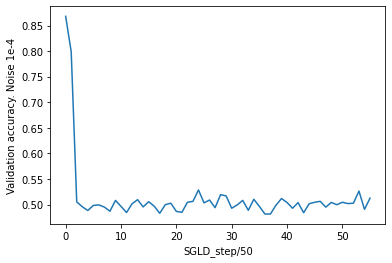

In [ ]:
plt.figure()
plt.plot(accuracy_graphs[1e-4])
plt.ylabel('Validation accuracy. Noise 1e-4')
plt.xlabel('SGLD_step/50')
plt.show()

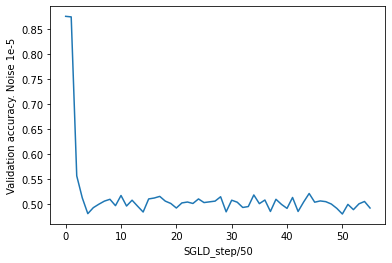

In [ ]:
plt.figure()
plt.plot(accuracy_graphs[1e-5])
plt.ylabel('Validation accuracy. Noise 1e-5')
plt.xlabel('SGLD_step/50')
plt.show()

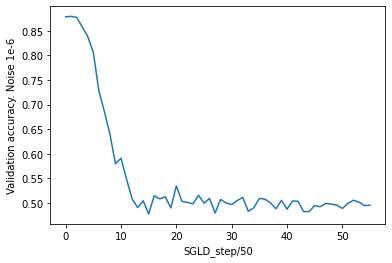

In [ ]:
plt.figure()
plt.plot(accuracy_graphs[1e-6])
plt.ylabel('Validation accuracy. Noise 1e-6')
plt.xlabel('SGLD_step/50')
plt.show()

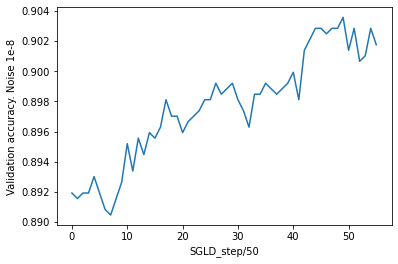

In [ ]:
plt.figure()
plt.plot(accuracy_graphs[1e-8])
plt.ylabel('Validation accuracy. Noise 1e-8')
plt.xlabel('SGLD_step/50')
plt.show()

As we can see, our BERT model is very sensitive to the amount of noise added in the SGLD. Unless the noise added is very small, it quickly falls off the optimum and it isn't able to learn. A reason for the behaviour we observe with SGLD is that, even though we are perturbing every weight by a very little amount, the total number of weights that we are perturbing is very big, so the total perturbation to the model could be significant. 

# Vadam: Approximating the posterior of the full model

We then try to train a full pretrained BERT model using variational Adam. We do a hyperparameter search over the prior precisions and posterior initializations but we don't observe any meaningful learning in any case. To give a better understanding of the quality of the results, we calculate tha accuracy of the pretrained BERT model without further fine tuning

In [ ]:
args = MyArgs()

In [ ]:
data_dir = '1_original_study_datasets'
train_name = "util_train"

In [ ]:
args.model = "bert-base-uncased"
args.learning_rate = 1e-5
args.batch_size = 16
args.nepochs = 2
prior_prec = [1e7, 1e5, 1e3, 1e1, 1e-1, 1e-3, 1e-5]
betas = (0.9,0.995)
train_mc_samples = 5
eval_mc_samples = 20

training_accuracy = {}
validation_accuracy = {}
test_accuracy = {}
hard_test_accuracy = {}

model, optimizer = load_model(args)
train_data = load_process_data(args, data_dir, "util", train_name)
train_set, validation_set = torch.utils.data.random_split(train_data, [int(0.8*len(train_data)), \
                                      len(train_data) - int(0.8*len(train_data))], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_set, batch_size=args.batch_size // 2, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=args.batch_size // 2, shuffle=False)


for precision in prior_prec:

  model, optimizer = load_model(args)

  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
      'weight_decay': args.weight_decay},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
      'weight_decay': 0.0}
  ]

  optimizer_vadam = Vadam(optimizer_grouped_parameters,
                lr = args.learning_rate,
                betas = betas,
                prior_prec = precision,
                prec_init = precision,
                train_set_size = len(train_set))
  
  for epoch in range(1, args.nepochs + 1):
    print()
    train_variational(model, optimizer_vadam, train_dataloader, epoch, verbose=True)
  training_accuracy[precision] = evaluate(model, train_dataloader)
  print(training_accuracy[precision])
  validation_accuracy[precision] = evaluate(model, validation_dataloader)
  print(validation_accuracy[precision])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded



train fraction of examples within context window (64 tokens): 1.000


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded

Train Epoch: 1 [10/1374 (1%)]	Loss: 0.710716
Train Epoch: 1 [20/1374 (1%)]	Loss: 0.774642
Train Epoch: 1 [30/1374 (2%)]	Loss: 0.696204
Train Epoch: 1 [40/1374 (3%)]	Loss: 0.657831
Train Epoch: 1 [50/1374 (4%)]	Loss: 0.731901
Train Epoch: 1 [60/1374 (4%)]	Loss: 0.706430
Train Epoch: 1 [70/1374 (5%)]	Loss: 0.672105
Train Epoch: 1 [80/1374 (6%)]	Loss: 0.687831
Train Epoch: 1 [90/1374 (7%)]	Loss: 0.731698
Train Epoch: 1 [100/1374 (7%)]	Loss: 0.687935
Train Epoch: 1 [110/1374 (8%)]	Loss: 0.725055
Train Epoch: 1 [120/1374 (9%)]	Loss: 0.696276
Train Epoch: 1 [130/1374 (9%)]	Loss: 0.711436
Train Epoch: 1 [140/1374 (10%)]	Loss: 0.766686
Train Epoch: 1 [150/1374 (11%)]	Loss: 0.741060
Train Epoch: 1 [160/1374 (12%)]	Loss: 0.720799
Train Epoch: 1 [170/1374 (12%)]	Loss: 0.680889
Train Epoch: 1 [180/1374 (13%)]	Loss: 0.693800
Train Epoch: 1 [190/1374 (14%)]	Loss: 0.666459
Train Epoch: 1 [200/1374 (15%)]	Loss: 0.660882
Train Epoch: 1 [210/1374 (15%)]	Loss

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded

Train Epoch: 1 [10/1374 (1%)]	Loss: 0.696862
Train Epoch: 1 [20/1374 (1%)]	Loss: 0.678134
Train Epoch: 1 [30/1374 (2%)]	Loss: 0.673557
Train Epoch: 1 [40/1374 (3%)]	Loss: 0.711939
Train Epoch: 1 [50/1374 (4%)]	Loss: 0.750184
Train Epoch: 1 [60/1374 (4%)]	Loss: 0.750676
Train Epoch: 1 [70/1374 (5%)]	Loss: 0.717843
Train Epoch: 1 [80/1374 (6%)]	Loss: 0.626564
Train Epoch: 1 [90/1374 (7%)]	Loss: 0.726499
Train Epoch: 1 [100/1374 (7%)]	Loss: 0.774144
Train Epoch: 1 [110/1374 (8%)]	Loss: 0.719055
Train Epoch: 1 [120/1374 (9%)]	Loss: 0.676648
Train Epoch: 1 [130/1374 (9%)]	Loss: 0.669590
Train Epoch: 1 [140/1374 (10%)]	Loss: 0.611122
Train Epoch: 1 [150/1374 (11%)]	Loss: 0.683408
Train Epoch: 1 [160/1374 (12%)]	Loss: 0.670714
Train Epoch: 1 [170/1374 (12%)]	Loss: 0.664357
Train Epoch: 1 [180/1374 (13%)]	Loss: 0.703466
Train Epoch: 1 [190/1374 (14%)]	Loss: 0.696056
Train Epoch: 1 [200/1374 (15%)]	Loss: 0.633874
Train Epoch: 1 [210/1374 (15%)]	Loss

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded

Train Epoch: 1 [10/1374 (1%)]	Loss: 0.797486
Train Epoch: 1 [20/1374 (1%)]	Loss: 0.950808
Train Epoch: 1 [30/1374 (2%)]	Loss: 0.599425
Train Epoch: 1 [40/1374 (3%)]	Loss: 0.700656
Train Epoch: 1 [50/1374 (4%)]	Loss: 0.952370
Train Epoch: 1 [60/1374 (4%)]	Loss: 0.851390
Train Epoch: 1 [70/1374 (5%)]	Loss: 0.636125
Train Epoch: 1 [80/1374 (6%)]	Loss: 0.740939
Train Epoch: 1 [90/1374 (7%)]	Loss: 0.791464
Train Epoch: 1 [100/1374 (7%)]	Loss: 0.807494
Train Epoch: 1 [110/1374 (8%)]	Loss: 0.618836
Train Epoch: 1 [120/1374 (9%)]	Loss: 0.891132
Train Epoch: 1 [130/1374 (9%)]	Loss: 0.913949
Train Epoch: 1 [140/1374 (10%)]	Loss: 0.720883
Train Epoch: 1 [150/1374 (11%)]	Loss: 0.806880
Train Epoch: 1 [160/1374 (12%)]	Loss: 0.644321
Train Epoch: 1 [170/1374 (12%)]	Loss: 0.937343
Train Epoch: 1 [180/1374 (13%)]	Loss: 0.772362
Train Epoch: 1 [190/1374 (14%)]	Loss: 0.732813
Train Epoch: 1 [200/1374 (15%)]	Loss: 0.732260
Train Epoch: 1 [210/1374 (15%)]	Loss

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded

Train Epoch: 1 [10/1374 (1%)]	Loss: 2.547065
Train Epoch: 1 [20/1374 (1%)]	Loss: 2.014702
Train Epoch: 1 [30/1374 (2%)]	Loss: 1.805563
Train Epoch: 1 [40/1374 (3%)]	Loss: 0.637688
Train Epoch: 1 [50/1374 (4%)]	Loss: 1.282903
Train Epoch: 1 [60/1374 (4%)]	Loss: 1.252607
Train Epoch: 1 [70/1374 (5%)]	Loss: 1.191140
Train Epoch: 1 [80/1374 (6%)]	Loss: 2.023918
Train Epoch: 1 [90/1374 (7%)]	Loss: 1.170390
Train Epoch: 1 [100/1374 (7%)]	Loss: 1.203955
Train Epoch: 1 [110/1374 (8%)]	Loss: 1.026917
Train Epoch: 1 [120/1374 (9%)]	Loss: 1.186266
Train Epoch: 1 [130/1374 (9%)]	Loss: 0.673558
Train Epoch: 1 [140/1374 (10%)]	Loss: 0.844965
Train Epoch: 1 [150/1374 (11%)]	Loss: 1.034851
Train Epoch: 1 [160/1374 (12%)]	Loss: 0.840257
Train Epoch: 1 [170/1374 (12%)]	Loss: 0.835955
Train Epoch: 1 [180/1374 (13%)]	Loss: 1.099810
Train Epoch: 1 [190/1374 (14%)]	Loss: 0.801794
Train Epoch: 1 [200/1374 (15%)]	Loss: 0.634672
Train Epoch: 1 [210/1374 (15%)]	Loss

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded

Train Epoch: 1 [10/1374 (1%)]	Loss: 3.229981
Train Epoch: 1 [20/1374 (1%)]	Loss: 0.884662
Train Epoch: 1 [30/1374 (2%)]	Loss: 1.627972
Train Epoch: 1 [40/1374 (3%)]	Loss: 1.062229
Train Epoch: 1 [50/1374 (4%)]	Loss: 1.222311
Train Epoch: 1 [60/1374 (4%)]	Loss: 0.936464
Train Epoch: 1 [70/1374 (5%)]	Loss: 1.171444
Train Epoch: 1 [80/1374 (6%)]	Loss: 1.023292
Train Epoch: 1 [90/1374 (7%)]	Loss: 1.031242
Train Epoch: 1 [100/1374 (7%)]	Loss: 0.704411
Train Epoch: 1 [110/1374 (8%)]	Loss: 1.071424
Train Epoch: 1 [120/1374 (9%)]	Loss: 0.608321
Train Epoch: 1 [130/1374 (9%)]	Loss: 0.938381
Train Epoch: 1 [140/1374 (10%)]	Loss: 1.392628
Train Epoch: 1 [150/1374 (11%)]	Loss: 0.986003
Train Epoch: 1 [160/1374 (12%)]	Loss: 1.196683
Train Epoch: 1 [170/1374 (12%)]	Loss: 0.301595
Train Epoch: 1 [180/1374 (13%)]	Loss: 0.474613
Train Epoch: 1 [190/1374 (14%)]	Loss: 0.527872
Train Epoch: 1 [200/1374 (15%)]	Loss: 0.322585
Train Epoch: 1 [210/1374 (15%)]	Loss

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded

Train Epoch: 1 [10/1374 (1%)]	Loss: 5.750261
Train Epoch: 1 [20/1374 (1%)]	Loss: 2.479404
Train Epoch: 1 [30/1374 (2%)]	Loss: 1.241204
Train Epoch: 1 [40/1374 (3%)]	Loss: 1.761586
Train Epoch: 1 [50/1374 (4%)]	Loss: 0.785084
Train Epoch: 1 [60/1374 (4%)]	Loss: 1.436671
Train Epoch: 1 [70/1374 (5%)]	Loss: 1.265064
Train Epoch: 1 [80/1374 (6%)]	Loss: 1.091483
Train Epoch: 1 [90/1374 (7%)]	Loss: 1.154819
Train Epoch: 1 [100/1374 (7%)]	Loss: 1.355450
Train Epoch: 1 [110/1374 (8%)]	Loss: 1.116030
Train Epoch: 1 [120/1374 (9%)]	Loss: 0.692133
Train Epoch: 1 [130/1374 (9%)]	Loss: 1.111783
Train Epoch: 1 [140/1374 (10%)]	Loss: 0.919524
Train Epoch: 1 [150/1374 (11%)]	Loss: 1.535683
Train Epoch: 1 [160/1374 (12%)]	Loss: 0.976476
Train Epoch: 1 [170/1374 (12%)]	Loss: 1.137289
Train Epoch: 1 [180/1374 (13%)]	Loss: 1.307261
Train Epoch: 1 [190/1374 (14%)]	Loss: 1.163611
Train Epoch: 1 [200/1374 (15%)]	Loss: 1.414545
Train Epoch: 1 [210/1374 (15%)]	Loss

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded

Train Epoch: 1 [10/1374 (1%)]	Loss: 3.091805
Train Epoch: 1 [20/1374 (1%)]	Loss: 1.108741
Train Epoch: 1 [30/1374 (2%)]	Loss: 1.495963
Train Epoch: 1 [40/1374 (3%)]	Loss: 1.282913
Train Epoch: 1 [50/1374 (4%)]	Loss: 0.740506
Train Epoch: 1 [60/1374 (4%)]	Loss: 1.289604
Train Epoch: 1 [70/1374 (5%)]	Loss: 2.003893
Train Epoch: 1 [80/1374 (6%)]	Loss: 1.060304
Train Epoch: 1 [90/1374 (7%)]	Loss: 1.232226
Train Epoch: 1 [100/1374 (7%)]	Loss: 1.150194
Train Epoch: 1 [110/1374 (8%)]	Loss: 1.202738
Train Epoch: 1 [120/1374 (9%)]	Loss: 1.232707
Train Epoch: 1 [130/1374 (9%)]	Loss: 0.671492
Train Epoch: 1 [140/1374 (10%)]	Loss: 1.070745
Train Epoch: 1 [150/1374 (11%)]	Loss: 0.889070
Train Epoch: 1 [160/1374 (12%)]	Loss: 0.707898
Train Epoch: 1 [170/1374 (12%)]	Loss: 0.822665
Train Epoch: 1 [180/1374 (13%)]	Loss: 1.228941
Train Epoch: 1 [190/1374 (14%)]	Loss: 0.816209
Train Epoch: 1 [200/1374 (15%)]	Loss: 1.068838
Train Epoch: 1 [210/1374 (15%)]	Loss

In [ ]:
validation_accuracy

{1e-05: 0.48653566229985445,
 0.001: 0.5178311499272198,
 0.1: 0.49563318777292575,
 10.0: 0.504730713245997,
 1000.0: 0.4657933042212518,
 100000.0: 0.485080058224163,
 10000000.0: 0.5018195050946143}

In [ ]:
#import pickle

#Save results
#f = open("hyperparameter_search_vadam_full_model_results_validation_final.pkl","wb")
#pickle.dump(validation_accuracy,f)
#f.close()

And now, for the pretrained non fine-tuned BERT the results are:

In [ ]:
model, optimizer = load_model(args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded


In [ ]:
evaluate(model, validation_dataloader)

Acc 0.478


0.47780203784570596

We clearly see that training the full model using variational Adam doesn't lead to good results. We conjecture that the reason for this is the additional stochasticity introduced in variational Adam via the weight perturbations, that makes it difficult for the model to learn. 

# Vadam: Approximating the posterior of the final layer after converging to a local optima in the original dataset

Given the impossibility of fine-tuning a full transformer using Vadam, we first do the fine-tuning using AdamW and, once we have converged to a local optimum, freeze all the layers except for the last one and start using Vadam, to approximate the posterior of the last layer parameters.We first apply this procedure to the already trained RoBERTa-large model provided by the authors in [Aligning AI with shared human values](https://arxiv.org/abs/2008.02275) (so we will only have to do the  Since the model has already been trained, we only perform the step of freezing all its layers except for the last one and using Vadam.

In [ ]:
args = MyArgs(model='roberta-large', ngpus=1)

In [ ]:
!pip install gdown
import gdown
!gdown https://drive.google.com/uc?id=1MHvSFbHjvzebib90wW378VtDAtn1WVxc

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'clas


Pretrained model "roberta-large" loaded


In [ ]:
model, optimizer = load_model(args, load_path='util_roberta-large.pt')

In [ ]:
data_dir = '1_original_study_datasets'
train_name = 'util_train'
test_name = "util_test"
hard_test_name = "util_test_hard"

In [ ]:
train_data = load_process_data(args, data_dir, "util", train_name)
test_hard_data = load_process_data(args, data_dir, "util", hard_test_name)
test_data = load_process_data(args, data_dir, "util", test_name)

train_dataloader = DataLoader(train_data, batch_size=args.batch_size // 2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size // 2, shuffle=False)
hard_test_dataloader = DataLoader(test_hard_data, batch_size=args.batch_size // 2, shuffle=False)


train fraction of examples within context window (64 tokens): 1.000
test_hard fraction of examples within context window (64 tokens): 1.000
test fraction of examples within context window (64 tokens): 0.999


In [ ]:
evaluate(model, test_dataloader)

Acc 0.795


0.7951331114808652

In [ ]:
for name, param in model.named_parameters():
    if name != 'module.classifier.out_proj.weight' and name != 'module.classifier.out_proj.bias':
      param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

module.classifier.out_proj.weight
module.classifier.out_proj.bias


In [ ]:
trainable_parameters = [model.module.classifier.out_proj.weight, model.module.classifier.out_proj.bias]

In [ ]:
args.learning_rate = 1e-5
args.batch_size = 8
args.nepochs = 10
betas = (0.9,0.995)
train_mc_samples = 5
eval_mc_samples = 20

In [ ]:
optimizer_vadam_last_layer = Vadam(trainable_parameters,
                lr = args.learning_rate,
                betas = betas,
                prior_prec = 1.0,
                prec_init = 1.0,
                num_samples = train_mc_samples,
                train_set_size = len(train_data))

In [ ]:
current_precisions = None
precisions_difference = []

In [ ]:
for epoch in range(args.nepochs):
  print()
  train_variational(model, optimizer_vadam_last_layer, train_dataloader, epoch, verbose=True)
  if epoch > 0:
    precisions_difference.append(torch.norm(optimizer_vadam_last_layer.get_weight_precs()[0][0][0] - current_precisions[0][0][0]))
    print(precisions_difference)
  epoch += 1
  current_precisions = copy.deepcopy(optimizer_vadam_last_layer.get_weight_precs())


Train Epoch: 0 [10/1718 (1%)]	Loss: 0.006286
Train Epoch: 0 [20/1718 (1%)]	Loss: 0.399527
Train Epoch: 0 [30/1718 (2%)]	Loss: 0.013437
Train Epoch: 0 [40/1718 (2%)]	Loss: 0.112780
Train Epoch: 0 [50/1718 (3%)]	Loss: 0.026368
Train Epoch: 0 [60/1718 (3%)]	Loss: 0.003922
Train Epoch: 0 [70/1718 (4%)]	Loss: 0.428415
Train Epoch: 0 [80/1718 (5%)]	Loss: 1.213376
Train Epoch: 0 [90/1718 (5%)]	Loss: 0.040242
Train Epoch: 0 [100/1718 (6%)]	Loss: 0.000012
Train Epoch: 0 [110/1718 (6%)]	Loss: 0.013660
Train Epoch: 0 [120/1718 (7%)]	Loss: 0.009063
Train Epoch: 0 [130/1718 (8%)]	Loss: 0.392876
Train Epoch: 0 [140/1718 (8%)]	Loss: 0.112663
Train Epoch: 0 [150/1718 (9%)]	Loss: 0.445972
Train Epoch: 0 [160/1718 (9%)]	Loss: 0.313800
Train Epoch: 0 [170/1718 (10%)]	Loss: 0.001037
Train Epoch: 0 [180/1718 (10%)]	Loss: 0.072593
Train Epoch: 0 [190/1718 (11%)]	Loss: 0.861905
Train Epoch: 0 [200/1718 (12%)]	Loss: 0.424671
Train Epoch: 0 [210/1718 (12%)]	Loss: 0.000181
Train Epoch: 0 [220/1718 (13%)]	Loss:

In [ ]:
evaluate(model, test_dataloader)

Acc 0.795


0.7949251247920133

In [ ]:
precisions_difference

[tensor(183.8548, device='cuda:0'),
 tensor(129.5867, device='cuda:0'),
 tensor(42.7446, device='cuda:0'),
 tensor(102.3077, device='cuda:0'),
 tensor(41.9390, device='cuda:0'),
 tensor(76.2712, device='cuda:0'),
 tensor(69.3225, device='cuda:0'),
 tensor(80.6471, device='cuda:0'),
 tensor(33.6152, device='cuda:0')]

In [ ]:
precs_roberta_original = optimizer_vadam_last_layer.get_weight_precs()

In [ ]:
precs_roberta_original

[[tensor([[11.6384, 13.8135, 11.2259,  ..., 12.6498, 12.0761, 13.9614]],
         device='cuda:0'), tensor([1.], device='cuda:0')]]

In [ ]:
std_weights = torch.sqrt(1./precs_roberta_original[0][0][0])
std_bias = torch.sqrt(1./precs_roberta_original[0][1][0])

In [ ]:
#Save models
#f = open("variational_training_original_roberta.pkl","wb")
#pickle.dump(model,f)
#f.close()

In [ ]:
#Save precisions
#f = open("precisions_weights_biases_original_roberta.pkl","wb")
#pickle.dump(precs_roberta_original,f)
#f.close()

Once the model has been trained, to make predictions we sample from the posterior weights, do the predictions for each of these samples, and average the results.

In [ ]:
results_roberta = variational_inference_uncertainties_roberta(model, std_weights, std_bias, test_dataloader, mc_samples = 20)

In [ ]:
results_roberta_hard = variational_inference_uncertainties_roberta(model, std_weights, std_bias, hard_test_dataloader, mc_samples = 20)

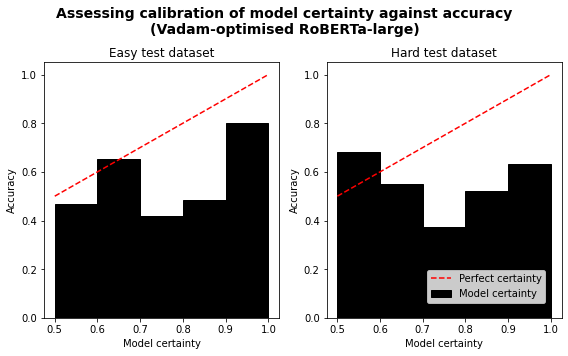

In [ ]:
conf, acc, bins, num_in_bins = split_in_bins(results_roberta['predictions'], results_roberta['confidence'])
conf_hard, acc_hard, bins_hard, num_in_bins_hard = split_in_bins(results_roberta_hard['predictions'], results_roberta_hard['confidence'])
ece_easy = get_ECE(conf, acc, num_in_bins)
print(f"ECE easy test dataset: {ece_easy}")
ece_hard = get_ECE(conf_hard, acc_hard, num_in_bins_hard)
print(f"ECE hard test dataset: {ece_hard}")
plot_reliability_diagram_original(acc, bins, acc_hard, bins_hard, "vadam_roberta_original")

In [ ]:
accuracy = np.mean(results_roberta['predictions'])

In [ ]:
accuracy

0.7945091514143094

In [ ]:
accuracy_hard = np.mean(results_roberta_hard['predictions'])

In [ ]:
accuracy_hard

0.6303838951310862

# Vadam: Approximating the posterior of the final layer after converging to a local optima in the reformulated dataset

We now do the sam as above but for a RoBERTa model that has been trained in the reformulated dataset

In [ ]:
args = MyArgs()

In [ ]:
args = MyArgs(model='roberta-large', ngpus=1)

In [ ]:
!pip install gdown
import gdown
!gdown https://drive.google.com/uc?id=1-Y19ljB76eESM6m8EVcZVeQjRfcNa7In

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Pretrained model "bert-base-uncased" loaded


In [ ]:
model, optimizer = load_model(args, load_path='final_rerelease_roberta-large_1e-05_16_2.pkl')

In [ ]:
data_dir = '4_reformulated_datasets'
train_name = 'util_train_no_test_overlap'
test_name = "util_test_easy_matched"
hard_test_name = "util_test_hard_matched"
unmatched_test_name = "test_combined_unmatched"

In [ ]:
train_data = load_process_data(args, data_dir, "util", train_name)
test_hard_data = load_process_data(args, data_dir, "util", hard_test_name)
test_data = load_process_data(args, data_dir, "util", test_name)
test_unmatched_data = load_process_data(args, data_dir, "util", unmatched_test_name)

train_dataloader = DataLoader(train_data, batch_size=args.batch_size // 2, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size // 2, shuffle=False)
hard_test_dataloader = DataLoader(test_hard_data, batch_size=args.batch_size // 2, shuffle=False)
unmatched_test_dataloader = DataLoader(test_unmatched_data, batch_size=args.batch_size // 2, shuffle=False)

In [ ]:
evaluate(model, test_dataloader)

Acc 0.976


0.9755371900826446

In [ ]:
evaluate(model, hard_test_dataloader)

Acc 0.727


0.7274323849666315

In [ ]:
for name, param in model.named_parameters():
    if name != 'module.classifier.out_proj.weight' and name != 'module.classifier.out_proj.bias':
      param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

module.classifier.out_proj.weight
module.classifier.out_proj.bias


In [ ]:
trainable_parameters = [model.module.classifier.out_proj.weight, model.module.classifier.out_proj.bias]

In [ ]:
args.learning_rate = 1e-5
args.batch_size = 8
args.nepochs = 10
betas = (0.9,0.995)
train_mc_samples = 5
eval_mc_samples = 20

In [ ]:
optimizer_vadam_last_layer = Vadam(trainable_parameters,
                lr = args.learning_rate,
                betas = betas,
                prior_prec = 1.0,
                prec_init = 1.0,
                num_samples = train_mc_samples,
                train_set_size = len(train_data))

In [ ]:
current_precisions = None
precisions_difference = []

In [ ]:
for epoch in range(args.nepochs):
  print()
  train_variational(model, optimizer_vadam_last_layer, train_dataloader, epoch, verbose=True)
  if epoch > 0:
    precisions_difference.append(torch.norm(optimizer_vadam_last_layer.get_weight_precs()[0][0][0] - current_precisions[0][0][0]))
    print(precisions_difference)
  epoch += 1
  current_precisions = copy.deepcopy(optimizer_vadam_last_layer.get_weight_precs())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: This overload of addcdiv_ is deprecated:
	addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcdiv_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)


Train Epoch: 0 [10/1485 (1%)]	Loss: 1.272528
Train Epoch: 0 [20/1485 (1%)]	Loss: 0.727781
Train Epoch: 0 [30/1485 (2%)]	Loss: 0.338296
Train Epoch: 0 [40/1485 (3%)]	Loss: 0.435092
Train Epoch: 0 [50/1485 (3%)]	Loss: 0.122471
Train Epoch: 0 [60/1485 (4%)]	Loss: 0.269610
Train Epoch: 0 [70/1485 (5%)]	Loss: 0.477961
Train Epoch: 0 [80/1485 (5%)]	Loss: 0.553490
Train Epoch: 0 [90/1485 (6%)]	Loss: 0.723457
Train Epoch: 0 [100/1485 (7%)]	Loss: 0.032279
Train Epoch: 0 [110/1485 (7%)]	Loss: 0.221996
Train Epoch: 0 [120/1485 (8%)]	Loss: 1.084319
Train Epoch: 0 [130/1485 (9%)]	Loss: 0.328190
Train Epoch: 0 [140/1485 (9%)]	Loss: 0.197676
Train Epoch: 0 [150/1485 (10%)]	Loss: 0.044588
Train Epoch: 0 [160/1485 (11%)]	Loss: 0.235096
Train Epoch: 0 [170/1485 (11%)]	Loss: 0.332862
Train Epoch: 0 [180/1485 (12%)]	Loss: 0.041235
Train Epoch: 0 [190/1485 (13%)]	Loss: 0.518321
Train Epoch: 0 [200/1485 (13%)]	Loss: 0.316497
Train Epoch: 0 [210/1485 (14%)]	Loss: 1.006649
Train Epoch: 0 [220/1485 (15%)]	Loss

In [ ]:
evaluate(model, test_dataloader)

Acc 0.975


0.9752066115702479

In [ ]:
evaluate(model, hard_test_dataloader)

Acc 0.728


0.7277836318932209

In [ ]:
precisions_difference

[tensor(135.8353, device='cuda:0'),
 tensor(144.3386, device='cuda:0'),
 tensor(65.9725, device='cuda:0'),
 tensor(69.7719, device='cuda:0'),
 tensor(41.3994, device='cuda:0'),
 tensor(46.8058, device='cuda:0'),
 tensor(57.7030, device='cuda:0'),
 tensor(41.1194, device='cuda:0'),
 tensor(45.9083, device='cuda:0')]

In [ ]:
precs_roberta_large = optimizer_vadam_last_layer.get_weight_precs()

In [ ]:
#Save models
#f = open("variational_training_rerelease_roberta_large_model.pkl","wb")
#pickle.dump(model,f)
#f.close()

In [ ]:
#Save precisions
#f = open("precisions_weights_biases_rerelease_roberta_large.pkl","wb")
#pickle.dump(precs_roberta_large,f)
#f.close()

In [ ]:
std_weights = torch.sqrt(1./precs_roberta_large[0][0][0])

In [ ]:
std_bias = torch.sqrt(1./precs_roberta_large[0][1][0])

In [ ]:
results_roberta_rerelease = variational_inference_uncertainties_roberta(model, std_weights, std_bias, test_dataloader, mc_samples = 20)

In [ ]:
results_roberta_hard_rerelease = variational_inference_uncertainties_roberta(model, std_weights, std_bias, hard_test_dataloader, mc_samples = 20)

In [ ]:
results_roberta_unmatched = variational_inference_uncertainties_roberta(model, std_weights, std_bias, unmatched_test_dataloader, mc_samples = 20)

In [ ]:
conf, acc, bins, num_in_bins = split_in_bins(results_roberta_rerelease['predictions'], results_roberta_rerelease['confidence'])
conf_hard, acc_hard, bins_hard, num_in_bins_hard = split_in_bins(results_roberta_hard_rerelease['predictions'], results_roberta_hard_rerelease['confidence'])
conf_unm, acc_unm, bins_unm, num_in_bins_unm = split_in_bins(results_roberta_unmatched['predictions'], results_roberta_unmatched['confidence'])
ece_easy = get_ECE(conf, acc, num_in_bins)
print(f"ECE easy test dataset: {ece_easy}")
ece_hard = get_ECE(conf_hard, acc_hard, num_in_bins_hard)
print(f"ECE hard test dataset: {ece_hard}")
ece_unmatched = get_ECE(conf_unm, acc_unm, num_in_bins_unm)
plot_reliability_diagram_rerelease(acc, bins, acc_hard, bins_hard, acc_unm, bins_unm, "variational_rerlease_roberta")
print(f"ECE unmatched test dataset: {ece_unmatched}")

In [ ]:
np.mean(results_roberta_rerelease['predictions'])

0.9742148760330579

In [ ]:
np.mean(results_roberta_hard_rerelease['predictions'])

0.7281348788198103

In [ ]:
np.mean(results_roberta_unmatched['predictions'])

0.49968671679197996

In [ ]:
#Save results
#f = open("results_variational_roberta_large_test_rerelease_final.pkl","wb")
#pickle.dump(results_roberta_large_test,f)
#f.close()

#f = open("results_variational_roberta_large_hard_test_rerelease_final.pkl","wb")
#pickle.dump(results_roberta_large_hard_test,f)
#f.close()